In [11]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

In [12]:
#chroms = [str(x) for x in range(1, 23)]
chroms = ['X']
ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'
ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'

In [43]:
PAR1X_end = 2699520
PAR2X_start = 154931044

In [13]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [14]:
print(Counter([len(v) for v in fam_to_inds.values()]))

Counter({4: 2500, 5: 421, 3: 258, 6: 69, 7: 13, 9: 4, 10: 1, 8: 1})


In [15]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

# Filter Families


In [16]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
    

In [17]:
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

X Families with all chroms 704
Counter({1: 704})
X Families with all chroms 309
Counter({1: 309})


In [18]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [19]:
# first, load positions
all_positions = []
for chrom in chroms:
    print(chrom, end=' ')
    positions = set()
    for j in ihart_family_sizes:
         with open('%s/chr.%s.familysize.%d.phased.txt' % (ihart_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in ihart_families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    
                    if state[0]==0 or state[1]==0 or state[2]==0 or state[3]==0:
                        positions.add(start_pos-1)
                        positions.add(start_pos)
                        positions.add(end_pos)
                        positions.add(end_pos+1)
                    
    for j in ssc_family_sizes:
         with open('%s/chr.%s.familysize.%d.phased.txt' % (ssc_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in ssc_families:
                    try:
                        state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                        if state[0]==0 or state[1]==0 or state[2]==0 or state[3]==0:
                            positions.add(start_pos-1)
                            positions.add(start_pos)
                            positions.add(end_pos)
                            positions.add(end_pos+1)
                    except:
                        print(pieces)
                        
    all_positions.append(sorted(positions))
                    
        

X 

In [44]:
from collections import defaultdict

# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2
gen_to_code = {(-1, -1): -1,
                   (-1, 0): 4,
                   (-1, 1): 3,
                   (0, -1): 4,
                   (0, 0): 2,
                   (0, 1): 1,
                   (1, -1): 3,
                   (1, 0): 1,
                   (1, 1): 0
                  }

ihart_deletions = [np.zeros((len(ihart_individuals), len(all_positions[i])), dtype=np.int8) for i in range(len(chroms))]
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    position_to_index = dict([(x, i) for i, x in enumerate(all_positions[i])])

    for j in ihart_family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (ihart_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in ihart_families:
                    inds = family_to_individuals[family_key]
                    indices = [ihart_ind_to_index[x] for x in inds]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    
                    in_par = (end_pos <= PAR1X_end) or (start_pos >= PAR2X_start)
                    if child_id_to_sex[inds[2]] == '2':
                        # female child
                        pat_copy = 2
                    else:
                        pat_copy = 3
                    
                    if state[0]==0 or state[1]==0 or (in_par and state[2]==0) or (in_par and state[3]==0) or (not in_par and state[pat_copy]==0):
                        start_index = position_to_index[start_pos]
                        end_index = position_to_index[end_pos+1]
                        
                        # mom
                        if state[0] == 0 and state[1] == 0:
                            pass
                        else:
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                                state[0] = -1
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                                state[1] = -1
                        ihart_deletions[i][indices[0], start_index:end_index] = gen_to_code[(state[0], state[1])]

                        # dad
                        if state[2] == 0 and state[3] == 0:
                            pass
                        else:
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                                state[2] = -1
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                                state[3] = -1
                        ihart_deletions[i][indices[1], start_index:end_index] = gen_to_code[(state[2], state[3])]

                        # children
                        for k in range(2, j):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]
                            if mom_s == -1:
                                mom_gen = -1
                            else:
                                mom_gen = state[mom_s]
                            if dad_s == -1:
                                dad_gen = -1
                            else:
                                dad_gen = state[2+dad_s]
                            ihart_deletions[i][indices[k], start_index:end_index] = gen_to_code[(mom_gen, dad_gen)]

                

X 

In [45]:
ssc_deletions = [np.zeros((len(ssc_individuals), len(all_positions[i])), dtype=np.int8) for i in range(len(chroms))]
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    position_to_index = dict([(x, i) for i, x in enumerate(all_positions[i])])

    for j in ssc_family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (ssc_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in ssc_families:
                    inds = family_to_individuals[family_key]
                    indices = [ssc_ind_to_index[x] for x in inds]
                    try:
                        state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        
                        in_par = (end_pos <= PAR1X_end) or (start_pos >= PAR2X_start)
                        if child_id_to_sex[inds[2]] == '2':
                            # female child
                            pat_copy = 2
                        else:
                            pat_copy = 3

                        if state[0]==0 or state[1]==0 or (in_par and state[2]==0) or (in_par and state[3]==0) or (not in_par and state[pat_copy]==0):
                            start_index = position_to_index[start_pos]
                            end_index = position_to_index[end_pos+1]

                            # mom
                            if state[0] == 0 and state[1] == 0:
                                pass
                            else:
                                if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                                    state[0] = -1
                                if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                                    state[1] = -1
                            ssc_deletions[i][indices[0], start_index:end_index] = gen_to_code[(state[0], state[1])]

                            # dad
                            if state[2] == 0 and state[3] == 0:
                                pass
                            else:
                                if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                                    state[2] = -1
                                if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                                    state[3] = -1
                            ssc_deletions[i][indices[1], start_index:end_index] = gen_to_code[(state[2], state[3])]

                            # children
                            for k in range(2, j):
                                mom_s, dad_s = state[(2*k):(2*(k+1))]
                                if mom_s == -1:
                                    mom_gen = -1
                                else:
                                    mom_gen = state[mom_s]
                                if dad_s == -1:
                                    dad_gen = -1
                                else:
                                    dad_gen = state[2+dad_s]
                                ssc_deletions[i][indices[k], start_index:end_index] = gen_to_code[(mom_gen, dad_gen)]
                    except:
                        pass

X 

# Run SDT

In [46]:

ihart_b = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]
ihart_c = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

ihart_b_f = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]
ihart_c_f = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

ihart_b_m = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]
ihart_c_m = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    for famkey in ihart_families:
        alleles = np.zeros((len(all_positions[i]), 2), dtype=float)
        counts = np.zeros((len(all_positions[i]), 2), dtype=float)
        
        alleles_f = np.zeros((len(all_positions[i]), 2), dtype=float)
        counts_f = np.zeros((len(all_positions[i]), 2), dtype=float)
        
        alleles_m = np.zeros((len(all_positions[i]), 2), dtype=float)
        counts_m = np.zeros((len(all_positions[i]), 2), dtype=float)

        inds = family_to_individuals[famkey]
        indices = [ihart_ind_to_index[x] for x in inds]
        
        for child_index, child in zip(indices[2:], inds[2:]):
            aff = int(child_id_to_affected[child] == '2')
            
            alleles[:, aff] += (ihart_deletions[i][child_index, :]==1).astype(int)
            alleles[:, aff] += 2*(ihart_deletions[i][child_index, :]==2).astype(int)
            counts[:, aff] += ((ihart_deletions[i][child_index, :] >= 0) & (ihart_deletions[i][child_index, :] <= 2)).astype(int)
            
            if aff == 0:
                alleles_f[:, aff] += (ihart_deletions[i][child_index, :]==1).astype(int)
                alleles_f[:, aff] += 2*(ihart_deletions[i][child_index, :]==2).astype(int)
                counts_f[:, aff] += ((ihart_deletions[i][child_index, :] >= 0) & (ihart_deletions[i][child_index, :] <= 2)).astype(int)

                alleles_m[:, aff] += (ihart_deletions[i][child_index, :]==1).astype(int)
                alleles_m[:, aff] += 2*(ihart_deletions[i][child_index, :]==2).astype(int)
                counts_m[:, aff] += ((ihart_deletions[i][child_index, :] >= 0) & (ihart_deletions[i][child_index, :] <= 2)).astype(int)

            elif aff == 1 and child_id_to_sex[child] == '2':
                alleles_f[:, aff] += (ihart_deletions[i][child_index, :]==1).astype(int)
                alleles_f[:, aff] += 2*(ihart_deletions[i][child_index, :]==2).astype(int)
                counts_f[:, aff] += ((ihart_deletions[i][child_index, :] >= 0) & (ihart_deletions[i][child_index, :] <= 2)).astype(int)

            elif aff == 1 and child_id_to_sex[child] == '1':
                alleles_m[:, aff] += (ihart_deletions[i][child_index, :]==1).astype(int)
                alleles_m[:, aff] += 2*(ihart_deletions[i][child_index, :]==2).astype(int)
                counts_m[:, aff] += ((ihart_deletions[i][child_index, :] >= 0) & (ihart_deletions[i][child_index, :] <= 2)).astype(int)

        ma = alleles[:, 1]/counts[:, 1]
        mu = alleles[:, 0]/counts[:, 0]
        d = ma-mu
        ihart_b[i] += ((~np.isnan(d)) & (~np.isinf(d)) & (d>0)).astype(int)
        ihart_c[i] += ((~np.isnan(d)) & (~np.isinf(d)) & (d<0)).astype(int)
        
        ma = alleles_f[:, 1]/counts_f[:, 1]
        mu = alleles_f[:, 0]/counts_f[:, 0]
        d = ma-mu
        ihart_b_f[i] += ((~np.isnan(d)) & (~np.isinf(d)) & (d>0)).astype(int)
        ihart_c_f[i] += ((~np.isnan(d)) & (~np.isinf(d)) & (d<0)).astype(int)
        
        ma = alleles_m[:, 1]/counts_f[:, 1]
        mu = alleles_m[:, 0]/counts_f[:, 0]
        d = ma-mu
        ihart_b_m[i] += ((~np.isnan(d)) & (~np.isinf(d)) & (d>0)).astype(int)
        ihart_c_m[i] += ((~np.isnan(d)) & (~np.isinf(d)) & (d<0)).astype(int)
        

X 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less
//anaconda/lib/python3.6/site-packages/ipykern

In [47]:

ssc_b = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]
ssc_c = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    for famkey in ssc_families:
        alleles = np.zeros((len(all_positions[i]), 2), dtype=float)
        counts = np.zeros((len(all_positions[i]), 2), dtype=float)

        inds = family_to_individuals[famkey]
        indices = [ssc_ind_to_index[x] for x in inds]
        
        for child_index, child in zip(indices[2:], inds[2:]):
            aff = int(child_id_to_affected[child] == '2')
            
            alleles[:, aff] += (ssc_deletions[i][child_index, :]==1).astype(int)
            alleles[:, aff] += 2*(ssc_deletions[i][child_index, :]==2).astype(int)
            counts[:, aff] += ((ssc_deletions[i][child_index, :] >= 0) & (ssc_deletions[i][child_index, :] <= 2)).astype(int)
            
        ma = alleles[:, 1]/counts[:, 1]
        mu = alleles[:, 0]/counts[:, 0]
        
        assert np.all(np.isnan(ma) | (ma <= 2))
        assert np.all(np.isnan(mu) | (mu <= 2))
        
        d = ma-mu
        ssc_b[i] += ((~np.isnan(d)) & (d>0)).astype(int)
        ssc_c[i] += ((~np.isnan(d)) & (d<0)).astype(int)
        

X 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [73]:
import scipy.stats

cached_pvalue = dict()
def calc_pvalue(b, c):
    k = (b, c)
    if k not in cached_pvalue:
        cached_pvalue[k] = 2*min(scipy.stats.binom.cdf(b, b+c, 0.5), scipy.stats.binom.cdf(c, b+c, 0.5))
    return cached_pvalue[k]

In [74]:
ihart_sdt_pvalues = [np.ones((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]
ihart_sdt_pvalues_f = [np.ones((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]
ihart_sdt_pvalues_m = [np.ones((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    for j in range(ihart_b[i].shape[0]):
        ihart_sdt_pvalues[i][j] = calc_pvalue(ihart_b[i][j], ihart_c[i][j])
        ihart_sdt_pvalues_f[i][j] = calc_pvalue(ihart_b_f[i][j], ihart_c_f[i][j])
        ihart_sdt_pvalues_m[i][j] = calc_pvalue(ihart_b_m[i][j], ihart_c_m[i][j])
        
        if (j==0) or (ihart_b[i][j] != ihart_b[i][j-1]) or (ihart_c[i][j] != ihart_c[i][j-1]):
            if ihart_b[i][j]+ihart_c[i][j]>20:
                num_tests += 1            
            
print(num_tests)

X 2558


In [75]:
ssc_sdt_pvalues = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

ssc_num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    for j in range(ssc_b[i].shape[0]):
        ssc_sdt_pvalues[i][j] = calc_pvalue(ssc_b[i][j], ssc_c[i][j])
        
        if (j==0) or (ssc_b[i][j] != ssc_b[i][j-1]) or (ssc_c[i][j] != ssc_c[i][j-1]):
            if ssc_b[i][j]+ssc_c[i][j]>20:
                ssc_num_tests += 1
            
print(ssc_num_tests)

X 2422


In [76]:
both_sdt_pvalues = [np.zeros((len(all_positions[i]),), dtype=float) for i in range(len(chroms))]

both_num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    both_b = ihart_b[i] + ssc_b[i]
    both_c = ihart_c[i] + ssc_c[i]
    
    for j in range(both_b.shape[0]):
        both_sdt_pvalues[i][j] = calc_pvalue(both_b[j], both_c[j])
        
        if (j==0) or (both_b[j] != both_b[j-1]) or (both_c[j] != both_c[j-1]):
            if both_b[j]+both_c[j]>20:
                both_num_tests += 1
            
print(both_num_tests)

X 5059


In [77]:
chrom_offsets = [0]
for chrom in chroms:
    chrom_offsets.append(chrom_offsets[-1]+chrom_lengths[chrom])
print(chrom_offsets)

[0, 155270560]


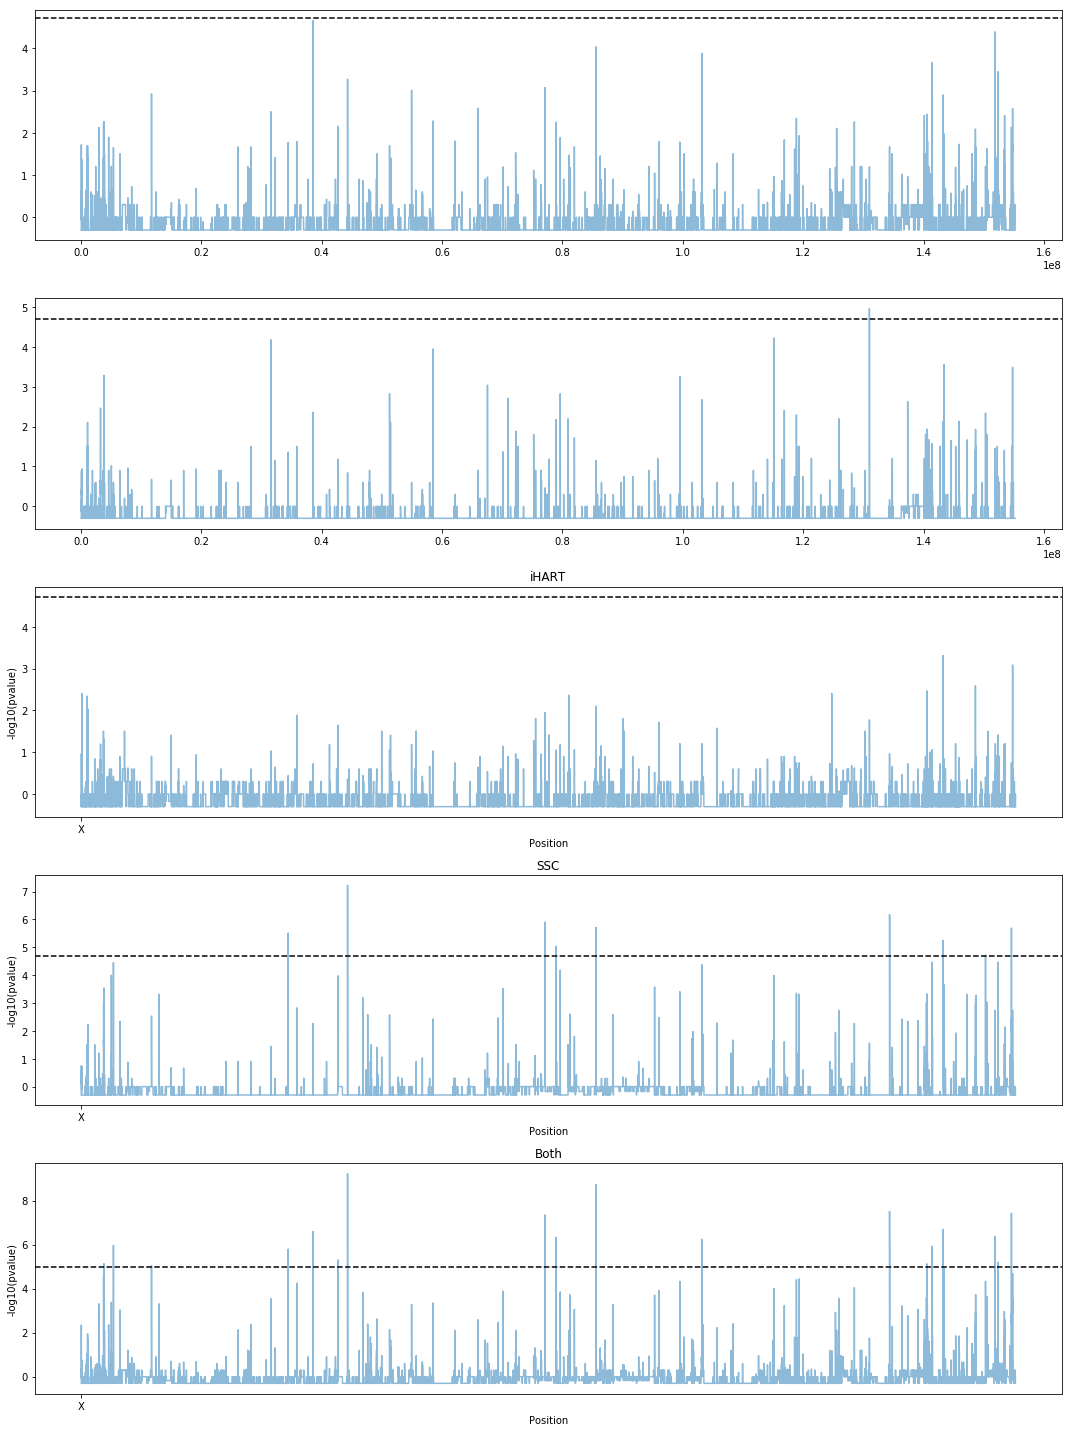

In [82]:
plt.figure(figsize=(15, 20))
  
plt.subplot(5, 1, 1)
for i in range(len(chroms)):
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_sdt_pvalues[i]), alpha=0.5)
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')

plt.subplot(5, 1, 2)
for i in range(len(chroms)):
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_sdt_pvalues_f[i]), alpha=0.5)
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')

plt.subplot(5, 1, 3)
for i in range(len(chroms)):
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_sdt_pvalues_m[i]), alpha=0.5)

plt.xticks(chrom_offsets[:-1], chroms)
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART')
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')

plt.subplot(5, 1, 4)
for i in range(len(chroms)): 
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ssc_sdt_pvalues[i]), alpha=0.5)

plt.xticks(chrom_offsets[:-1], chroms)
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('SSC')
plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')

plt.subplot(5, 1, 5)
for i in range(len(chroms)):
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(both_sdt_pvalues[i]), alpha=0.5)

plt.xticks(chrom_offsets[:-1], chroms)
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Both')
plt.axhline(-np.log10(0.05/both_num_tests), linestyle='--', color='black')

plt.tight_layout()
plt.show()

In [54]:
for i, chrom in enumerate(chroms):
    max_index = np.argmax(-np.log10(both_sdt_pvalues[i]))
    print(chrom, all_positions[i][max_index], -np.log10(ihart_sdt_pvalues[i][max_index]), -np.log10(ssc_sdt_pvalues[i][max_index]), -np.log10(both_sdt_pvalues[i][max_index]))
    
    
    

X 44302536 3.271171536206005 6.340406010038439 9.218878812852516


# Run TDT (including unaffected)

In [55]:
ihart_contingency = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]
ihart_contingency_f = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]
ihart_contingency_m = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    for famkey in ihart_families:
        inds = family_to_individuals[famkey]
        indices = [ihart_ind_to_index[x] for x in inds]
        mom_index, dad_index = indices[:2]
        for child_index, child in zip(indices[2:], inds[2:]):
            a = ((ihart_deletions[i][mom_index, :]==0) & (ihart_deletions[i][dad_index, :]==1) & (ihart_deletions[i][child_index, :]==1)) \
                + ((ihart_deletions[i][mom_index, :]==1) & (ihart_deletions[i][dad_index, :]==0) & (ihart_deletions[i][child_index, :]==1)) \
                + ((ihart_deletions[i][mom_index, :]==2) & (ihart_deletions[i][dad_index, :]==1) & (ihart_deletions[i][child_index, :]==2)) \
                + ((ihart_deletions[i][mom_index, :]==1) & (ihart_deletions[i][dad_index, :]==2) & (ihart_deletions[i][child_index, :]==2))

            b = ((ihart_deletions[i][mom_index, :]==0) & (ihart_deletions[i][dad_index, :]==1) & (ihart_deletions[i][child_index, :]==0)) \
                + ((ihart_deletions[i][mom_index, :]==1) & (ihart_deletions[i][dad_index, :]==0) & (ihart_deletions[i][child_index, :]==0)) \
                + ((ihart_deletions[i][mom_index, :]==2) & (ihart_deletions[i][dad_index, :]==1) & (ihart_deletions[i][child_index, :]==1)) \
                + ((ihart_deletions[i][mom_index, :]==1) & (ihart_deletions[i][dad_index, :]==2) & (ihart_deletions[i][child_index, :]==1)) 

            aff = int(child_id_to_affected[child] == '2')
            ihart_contingency[i][:, aff, 1] += a
            ihart_contingency[i][:, aff, 0] += b

            
            if child_id_to_sex[child] == '2':
                ihart_contingency_f[i][:, aff, 1] += a
                ihart_contingency_f[i][:, aff, 0] += b
            else:
                ihart_contingency_m[i][:, aff, 1] += a
                ihart_contingency_m[i][:, aff, 0] += b
                                          

X 

In [56]:
ssc_contingency = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]
ssc_contingency_f = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]
ssc_contingency_m = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    for famkey in ssc_families:
        inds = family_to_individuals[famkey]
        indices = [ssc_ind_to_index[x] for x in inds]
        mom_index, dad_index = indices[:2]
        for child_index, child in zip(indices[2:], inds[2:]):
            a = ((ssc_deletions[i][mom_index, :]==0) & \
                 (ssc_deletions[i][dad_index, :]==1) & \
                 (ssc_deletions[i][child_index, :]==1)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                   (ssc_deletions[i][dad_index, :]==0) & \
                   (ssc_deletions[i][child_index, :]==1)) \
                + ((ssc_deletions[i][mom_index, :]==2) & \
                   (ssc_deletions[i][dad_index, :]==1) & \
                   (ssc_deletions[i][child_index, :]==2)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                    (ssc_deletions[i][dad_index, :]==2) & \
                    (ssc_deletions[i][child_index, :]==2))
            
            #a = (((ssc_deletions[i][mom_index, :]==0) | (ssc_deletions[i][mom_index, :]==3)) & \
            #     ((ssc_deletions[i][dad_index, :]==1) | (ssc_deletions[i][dad_index, :]==4)) & \
            #     (ssc_deletions[i][child_index, :]==1)) \
            #    + (((ssc_deletions[i][mom_index, :]==1) | (ssc_deletions[i][mom_index, :]==4)) & \
            #       ((ssc_deletions[i][dad_index, :]==0) | (ssc_deletions[i][dad_index, :]==3)) & \
            #       (ssc_deletions[i][child_index, :]==1)) \
            #    + ((ssc_deletions[i][mom_index, :]==2) & \
            #       ((ssc_deletions[i][dad_index, :]==1) | (ssc_deletions[i][dad_index, :]==4)) & \
            #       (ssc_deletions[i][child_index, :]==2)) \
            #    + (((ssc_deletions[i][mom_index, :]==1) | (ssc_deletions[i][mom_index, :]==4)) & \
            #        (ssc_deletions[i][dad_index, :]==2) & \
            #        (ssc_deletions[i][child_index, :]==2))

            b = ((ssc_deletions[i][mom_index, :]==0) & \
                 (ssc_deletions[i][dad_index, :]==1) & \
                 (ssc_deletions[i][child_index, :]==0)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                   (ssc_deletions[i][dad_index, :]==0) & \
                  (ssc_deletions[i][child_index, :]==0)) \
                + ((ssc_deletions[i][mom_index, :]==2) & \
                   (ssc_deletions[i][dad_index, :]==1) & \
                   (ssc_deletions[i][child_index, :]==1)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                   (ssc_deletions[i][dad_index, :]==2) & \
                   (ssc_deletions[i][child_index, :]==1))
            
            #b = (((ssc_deletions[i][mom_index, :]==0) | (ssc_deletions[i][mom_index, :]==3)) & \
            #     ((ssc_deletions[i][dad_index, :]==1) | (ssc_deletions[i][dad_index, :]==4)) & \
            #     (ssc_deletions[i][child_index, :]==0)) \
            #    + (((ssc_deletions[i][mom_index, :]==1) | (ssc_deletions[i][mom_index, :]==4)) & \
            #       ((ssc_deletions[i][dad_index, :]==0) | (ssc_deletions[i][dad_index, :]==3)) & \
            #      (ssc_deletions[i][child_index, :]==0)) \
            #    + ((ssc_deletions[i][mom_index, :]==2) & \
            #       ((ssc_deletions[i][dad_index, :]==1) | (ssc_deletions[i][dad_index, :]==4)) & \
            #       (ssc_deletions[i][child_index, :]==1)) \
            #    + (((ssc_deletions[i][mom_index, :]==1) | (ssc_deletions[i][mom_index, :]==4)) & \
            #       (ssc_deletions[i][dad_index, :]==2) & \
            #       (ssc_deletions[i][child_index, :]==1))

            aff = int(child_id_to_affected[child] == '2')
            ssc_contingency[i][:, aff, 1] += a
            ssc_contingency[i][:, aff, 0] += b

            
            if child_id_to_sex[child] == '2':
                ssc_contingency_f[i][:, aff, 1] += a
                ssc_contingency_f[i][:, aff, 0] += b
            else:
                ssc_contingency_m[i][:, aff, 1] += a
                ssc_contingency_m[i][:, aff, 0] += b
                                          

X 

In [57]:
import scipy.stats

def calc_hypergeometric_pvalue(ct):
    aut_trans, typ_trans, aut_notrans, typ_notrans = ct[1, 1], ct[0, 1], ct[1, 0], ct[0, 0]
    trans_op = typ_trans + aut_trans + aut_notrans + typ_notrans
    trans = typ_trans + aut_trans
    
    if aut_trans/(aut_trans+aut_notrans) > typ_trans/(typ_trans+typ_notrans):
        return min(1, 2*scipy.stats.hypergeom.sf(aut_trans, trans_op, aut_trans+aut_notrans, trans) + scipy.stats.hypergeom.pmf(aut_trans, trans_op, aut_trans+aut_notrans, trans))
    else:
        return min(1, 2*scipy.stats.hypergeom.cdf(aut_trans, trans_op, aut_trans+aut_notrans, trans))

cached_pvalue = dict()
def calc_pvalue(ct):
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    return cached_pvalue[k]

In [58]:
ihart_pvalues = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]
ihart_pvalues_f = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]
ihart_pvalues_m = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]

num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    for j in range(ihart_contingency[i].shape[0]):
        if np.sum(ihart_contingency[i][j, :, :]) != 0:
            ihart_pvalues[i][j] = calc_pvalue(ihart_contingency[i][j, :, :])
            ihart_pvalues_f[i][j] = calc_pvalue(ihart_contingency_f[i][j, :, :])
            ihart_pvalues_m[i][j] = calc_pvalue(ihart_contingency_m[i][j, :, :])
            
            if j == 0 or np.any(ihart_contingency[i][j, :, :] != ihart_contingency[i][j-1, :, :]):
                num_tests += 1
            if j == 0 or np.any(ihart_contingency_f[i][j, :, :] != ihart_contingency_f[i][j-1, :, :]):
                num_tests += 1
            if j == 0 or np.any(ihart_contingency_m[i][j, :, :] != ihart_contingency_m[i][j-1, :, :]):
                num_tests += 1
print(num_tests)

X 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


14752


In [59]:
ssc_pvalues = [np.zeros((len(all_positions[i]),)) for i in range(len(chroms))]
ssc_pvalues_f = [np.zeros((len(all_positions[i]),)) for i in range(len(chroms))]
ssc_pvalues_m = [np.zeros((len(all_positions[i]),)) for i in range(len(chroms))]

ssc_num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    for j in range(ssc_contingency[i].shape[0]):
        if np.sum(ssc_contingency[i][j, :, :]) != 0:
            ssc_pvalues[i][j] = calc_pvalue(ssc_contingency[i][j, :, :])
            ssc_pvalues_f[i][j] = calc_pvalue(ssc_contingency_f[i][j, :, :])
            ssc_pvalues_m[i][j] = calc_pvalue(ssc_contingency_m[i][j, :, :])
            
            if j == 0 or np.any(ssc_contingency[i][j, :, :] != ssc_contingency[i][j-1, :, :]):
                ssc_num_tests += 1
            if j == 0 or np.any(ssc_contingency_f[i][j, :, :] != ssc_contingency_f[i][j-1, :, :]):
                ssc_num_tests += 1
            if j == 0 or np.any(ssc_contingency_m[i][j, :, :] != ssc_contingency_m[i][j-1, :, :]):
                ssc_num_tests += 1
print(ssc_num_tests)

X 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


5771


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


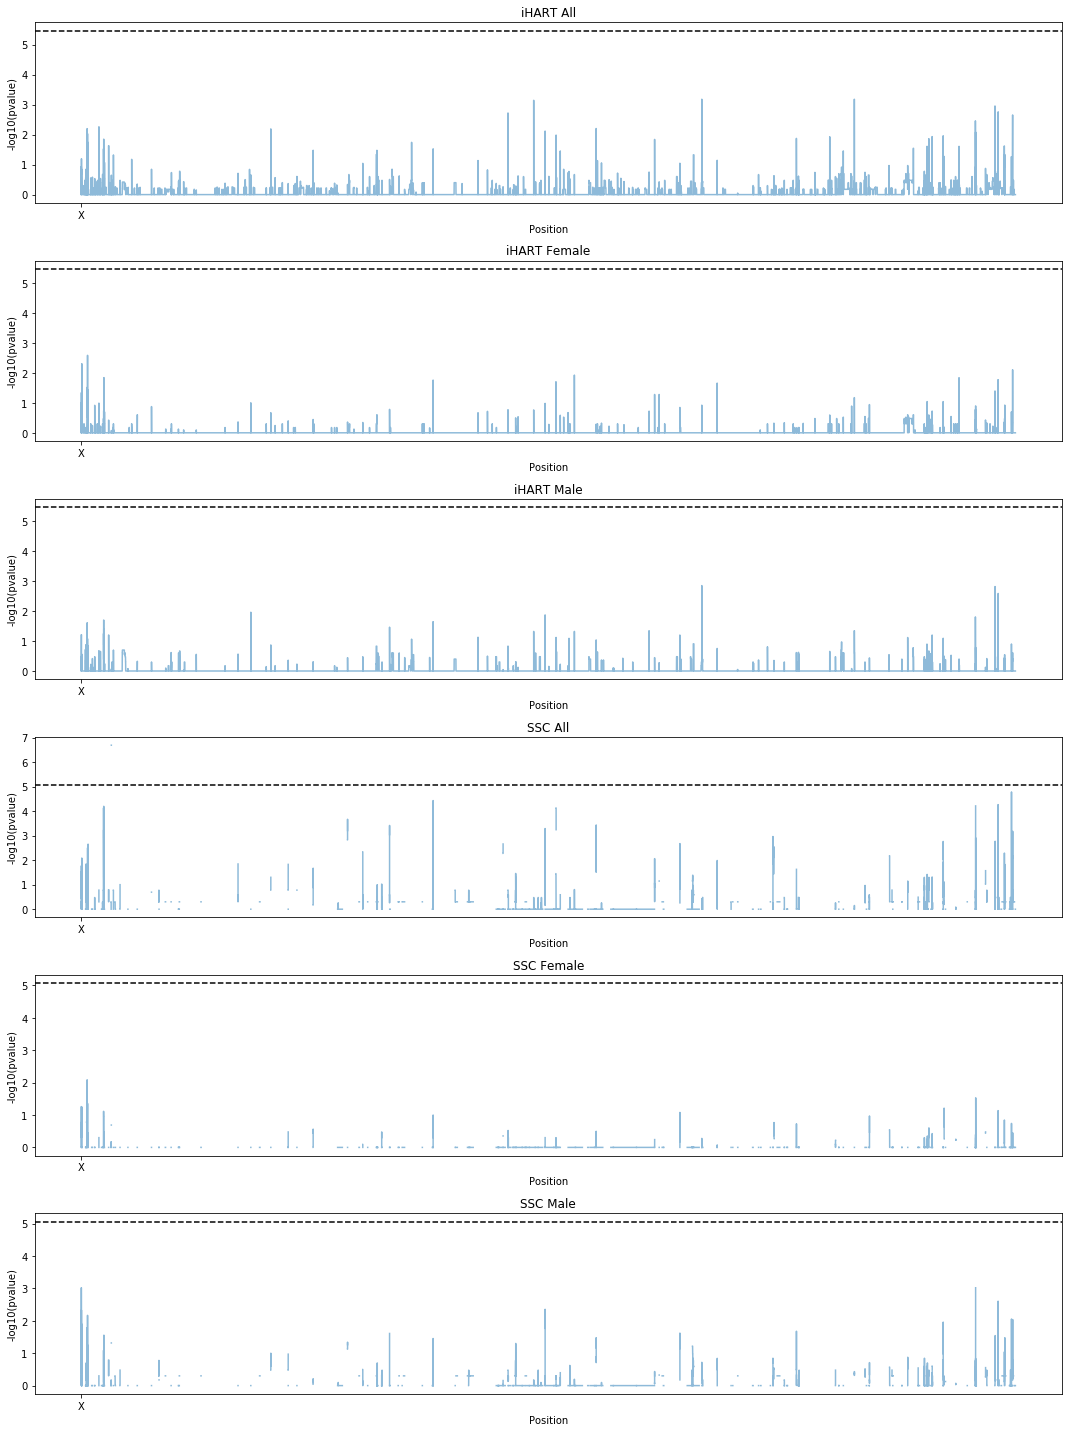

In [60]:
plt.figure(figsize=(15, 20))
  
for i in range(len(chroms)):
    plt.subplot(6, 1, 1)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_pvalues[i]), alpha=0.5)
    plt.subplot(6, 1, 2)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_pvalues_f[i]), alpha=0.5)
    plt.subplot(6, 1, 3)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_pvalues_m[i]), alpha=0.5)

for i in range(1, 7):
    plt.subplot(6, 1, i)
    plt.xticks(chrom_offsets[:-1], chroms)
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    #plt.ylim([0, 7])
    
plt.subplot(6, 1, 1)
plt.title('iHART All')
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 2)
plt.title('iHART Female')
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 3)
plt.title('iHART Male')
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')

for i in range(len(chroms)):
    plt.subplot(6, 1, 4)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ssc_pvalues[i]), alpha=0.5)
    plt.subplot(6, 1, 5)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ssc_pvalues_f[i]), alpha=0.5)
    plt.subplot(6, 1, 6)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ssc_pvalues_m[i]), alpha=0.5)
    
plt.subplot(6, 1, 4)
plt.title('SSC All')
plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 5)
plt.title('SSC Female')
plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 6)
plt.title('SSC Male')
plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')

plt.tight_layout()
plt.show()

# Run True TDT

In [61]:
ssc_contingency = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]
ssc_contingency_f = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]
ssc_contingency_m = [np.zeros((len(all_positions[i]), 2, 2), dtype=int) for i in range(len(chroms))]

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    for famkey in ssc_families:
        inds = family_to_individuals[famkey]
        indices = [ssc_ind_to_index[x] for x in inds]
        mom_index, dad_index = indices[:2]
        for child_index, child in zip(indices[2:], inds[2:]):
            a = ((ssc_deletions[i][mom_index, :]==0) & \
                 (ssc_deletions[i][dad_index, :]==1) & \
                 (ssc_deletions[i][child_index, :]==1)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                   (ssc_deletions[i][dad_index, :]==0) & \
                   (ssc_deletions[i][child_index, :]==1)) \
                + ((ssc_deletions[i][mom_index, :]==2) & \
                   (ssc_deletions[i][dad_index, :]==1) & \
                   (ssc_deletions[i][child_index, :]==2)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                    (ssc_deletions[i][dad_index, :]==2) & \
                    (ssc_deletions[i][child_index, :]==2))

            b = ((ssc_deletions[i][mom_index, :]==0) & \
                 (ssc_deletions[i][dad_index, :]==1) & \
                 (ssc_deletions[i][child_index, :]==0)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                   (ssc_deletions[i][dad_index, :]==0) & \
                  (ssc_deletions[i][child_index, :]==0)) \
                + ((ssc_deletions[i][mom_index, :]==2) & \
                   (ssc_deletions[i][dad_index, :]==1) & \
                   (ssc_deletions[i][child_index, :]==1)) \
                + ((ssc_deletions[i][mom_index, :]==1) & \
                   (ssc_deletions[i][dad_index, :]==2) & \
                   (ssc_deletions[i][child_index, :]==1))

            aff = int(child_id_to_affected[child] == '2')
            ssc_contingency[i][:, aff, 1] += a
            ssc_contingency[i][:, aff, 0] += b

            
            if child_id_to_sex[child] == '2':
                ssc_contingency_f[i][:, aff, 1] += a
                ssc_contingency_f[i][:, aff, 0] += b
            else:
                ssc_contingency_m[i][:, aff, 1] += a
                ssc_contingency_m[i][:, aff, 0] += b
                                          

X 

In [62]:
import scipy.stats

cached_pvalue = dict()
def calc_pvalue(ct):
    b1, c1 = ct[1, 0], ct[1, 1]
    b2, c2 = ct[0, 0], ct[0, 1]
    k = (b1, c1, b2, c2)
    if k not in cached_pvalue:
        cached_pvalue[k] = (scipy.stats.binom_test(b1, b1+c1, 0.5, alternative='two-sided'), scipy.stats.binom_test(b2, b2+c2, 0.5, alternative='two-sided'))
    return cached_pvalue[k]

In [63]:
ihart_pvalues_a = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]
ihart_pvalues_u = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]

num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    for j in range(ihart_contingency[i].shape[0]):
        if np.sum(ihart_contingency[i][j, :, :]) != 0:
            ihart_pvalues_a[i][j], ihart_pvalues_u[i][j] = calc_pvalue(ihart_contingency[i][j, :, :])
            
            if j == 0 or np.any(ihart_contingency[i][j, :, :] != ihart_contingency[i][j-1, :, :]):
                num_tests += 1

print(num_tests)

X 5191


In [64]:
ssc_pvalues_a = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]
ssc_pvalues_u = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]

ssc_num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    for j in range(ssc_contingency[i].shape[0]):
        if np.sum(ssc_contingency[i][j, :, :]) != 0:
            ssc_pvalues_a[i][j], ssc_pvalues_u[i][j] = calc_pvalue(ssc_contingency[i][j, :, :])
            
            if j == 0 or np.any(ssc_contingency[i][j, :, :] != ssc_contingency[i][j-1, :, :]):
                ssc_num_tests += 1

print(ssc_num_tests)

X 2114


In [65]:
both_pvalues_a = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]
both_pvalues_u = [np.ones((len(all_positions[i]),)) for i in range(len(chroms))]

both_num_tests = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    both_contingency = ihart_contingency[i] + ssc_contingency[i]
    for j in range(both_contingency.shape[0]):
        if np.sum(both_contingency[j, :, :]) != 0:
            both_pvalues_a[i][j], both_pvalues_u[i][j] = calc_pvalue(both_contingency[j, :, :])
            
            if j == 0 or np.any(both_contingency[j, :, :] != both_contingency[j-1, :, :]):
                both_num_tests += 1

print(both_num_tests)

X 6629


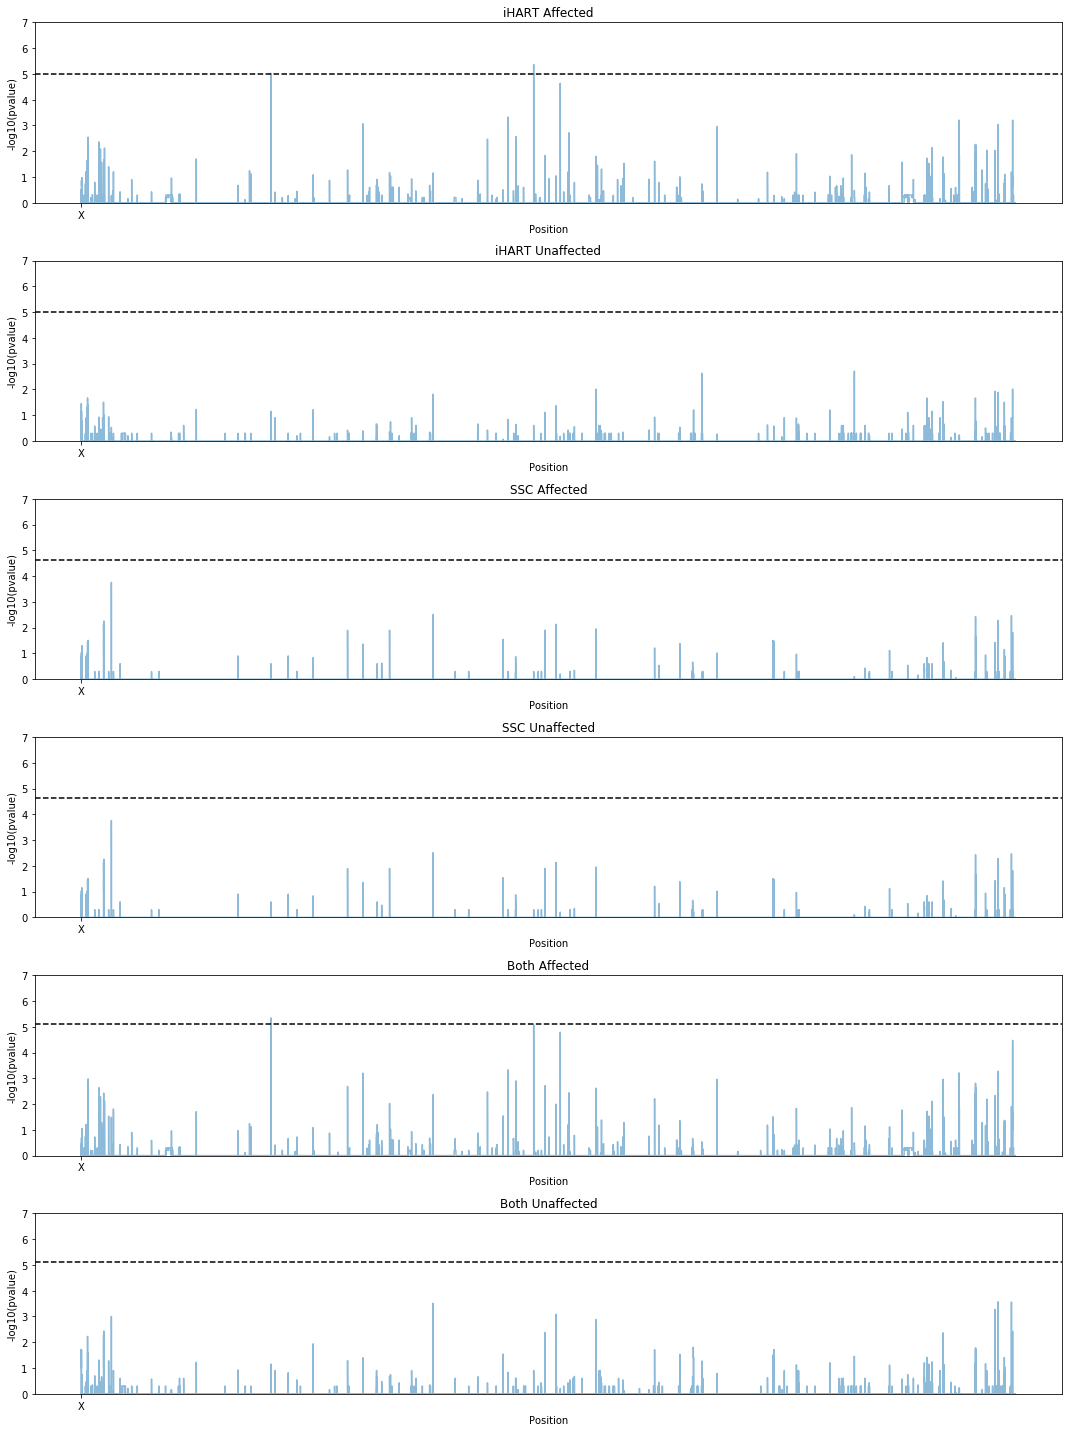

In [66]:
plt.figure(figsize=(15, 20))
  
for i in range(len(chroms)):
    plt.subplot(6, 1, 1)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_pvalues_a[i]), alpha=0.5)
    plt.subplot(6, 1, 2)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ihart_pvalues_u[i]), alpha=0.5)

for i in range(1, 7):
    plt.subplot(6, 1, i)
    plt.xticks(chrom_offsets[:-1], chroms)
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.ylim([0, 7])
    
plt.subplot(6, 1, 1)
plt.title('iHART Affected')
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 2)
plt.title('iHART Unaffected')
plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')

for i in range(len(chroms)):
    plt.subplot(6, 1, 3)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ssc_pvalues_a[i]), alpha=0.5)
    plt.subplot(6, 1, 4)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(ssc_pvalues_u[i]), alpha=0.5)
    
    
plt.subplot(6, 1, 3)
plt.title('SSC Affected')
plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 4)
plt.title('SSC Unaffected')
plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')

for i in range(len(chroms)):
    plt.subplot(6, 1, 5)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(both_pvalues_a[i]), alpha=0.5)
    plt.subplot(6, 1, 6)
    plt.plot(np.array(all_positions[i])+chrom_offsets[i], -np.log10(both_pvalues_u[i]), alpha=0.5)
    
    
plt.subplot(6, 1, 5)
plt.title('Both Affected')
plt.axhline(-np.log10(0.05/both_num_tests), linestyle='--', color='black')
plt.subplot(6, 1, 6)
plt.title('Both Unaffected')
plt.axhline(-np.log10(0.05/both_num_tests), linestyle='--', color='black')


plt.tight_layout()
plt.show()

# Regions of interest

In [62]:
def plot_region_of_interest(chrom, start_pos, end_pos):
    chrom_index = chroms.index(chrom)

    indices = np.where((np.array(all_positions[chrom_index])>=start_pos) & (np.array(all_positions[chrom_index])<=end_pos))[0]

    plt.figure(figsize=(15, 10))

    ax = plt.subplot(3, 3, 1)
    plt.title('TDT (include unaffected) iHART')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ihart_pvalues[chrom_index][indices]), label='All', alpha=0.5)
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ihart_pvalues_f[chrom_index][indices]), label='Female', alpha=0.5)
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ihart_pvalues_m[chrom_index][indices]), label='Male', alpha=0.5)
    plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.legend()

    plt.subplot(3, 3, 2, sharey=ax)
    plt.title('TDT (include unaffected) SSC')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ssc_pvalues[chrom_index][indices]), label='All', alpha=0.5)
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ssc_pvalues_f[chrom_index][indices]), label='Female', alpha=0.5)
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ssc_pvalues_m[chrom_index][indices]), label='Male', alpha=0.5)
    plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.legend()

    ax = plt.subplot(3, 3, 4)
    plt.title('SDT iHART')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ihart_sdt_pvalues[chrom_index][indices]), label='All', alpha=0.5)
    plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')

    plt.subplot(3, 3, 5, sharey=ax)
    plt.title('SDT SSC')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ssc_sdt_pvalues[chrom_index][indices]), label='All', alpha=0.5)
    plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    
    plt.subplot(3, 3, 6, sharey=ax)
    plt.title('SDT Both')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(both_sdt_pvalues[chrom_index][indices]), label='All', alpha=0.5)
    plt.axhline(-np.log10(0.05/both_num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')

    ax = plt.subplot(3, 3, 7)
    plt.title('True TDT iHART')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ihart_pvalues_a[chrom_index][indices]), label='Affected', alpha=0.5)
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ihart_pvalues_u[chrom_index][indices]), label='Unaffected', alpha=0.5)
    plt.axhline(-np.log10(0.05/num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.legend()

    plt.subplot(3, 3, 8, sharey=ax)
    plt.title('True TDT SSC')
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ssc_pvalues_a[chrom_index][indices]), label='Affected', alpha=0.5)
    plt.plot(np.array(all_positions[chrom_index])[indices], -np.log10(ssc_pvalues_u[chrom_index][indices]), label='Unaffected', alpha=0.5)
    plt.axhline(-np.log10(0.05/ssc_num_tests), linestyle='--', color='black')
    plt.ylabel('-log10(pvalue)')
    plt.xlabel('Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


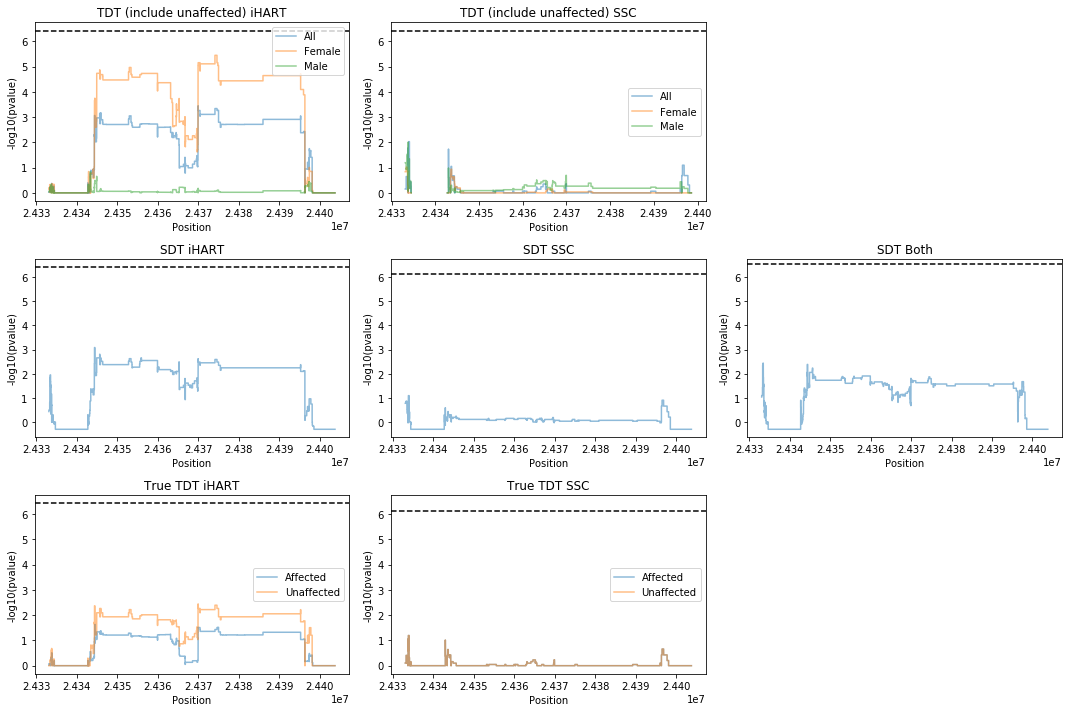

In [34]:
# deletion of GSTT1 and upstream regulatory elements
# common deletion, found in 1000kg

chrom, start_pos, end_pos = '22', 24332998, 24406719
plot_region_of_interest(chrom, start_pos, end_pos)

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


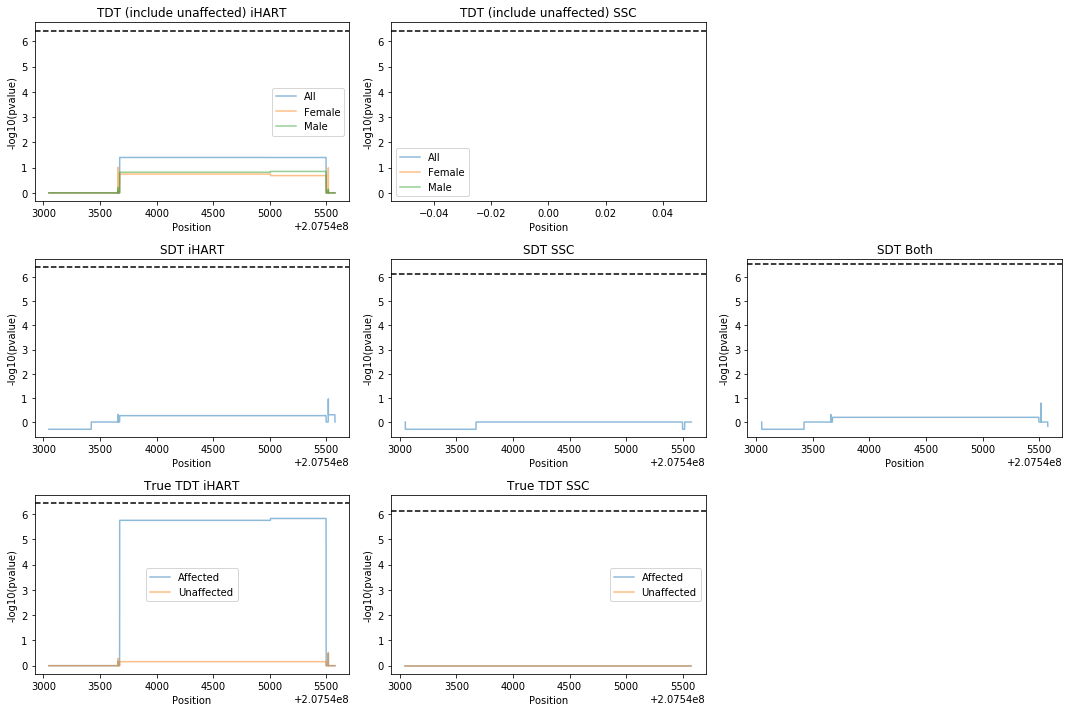

In [64]:
# upstream of CR2
chrom, start_pos, end_pos = '1', 207543000, 207546000
plot_region_of_interest(chrom, start_pos, end_pos)

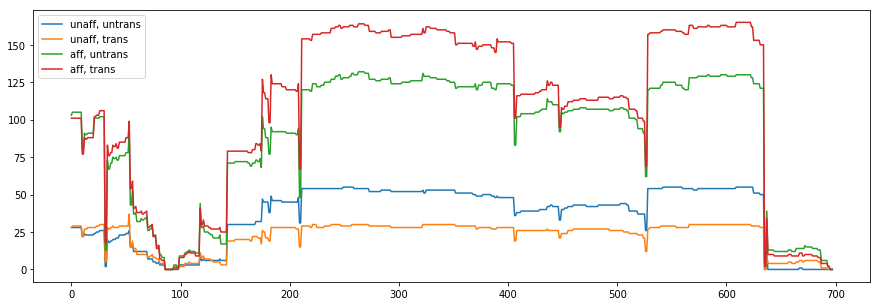

In [39]:
chrom, start_pos, end_pos = '22', 24332998, 24406719

c = ihart_contingency[-1][(np.array(all_positions[-1])>=start_pos) & (np.array(all_positions[-1])<=end_pos)]

plt.figure(figsize=(15, 5))
plt.plot(c[:, 0, 0], label='unaff, untrans')
plt.plot(c[:, 0, 1], label='unaff, trans')
plt.plot(c[:, 1, 0], label='aff, untrans')
plt.plot(c[:, 1, 1], label='aff, trans')

plt.legend()
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


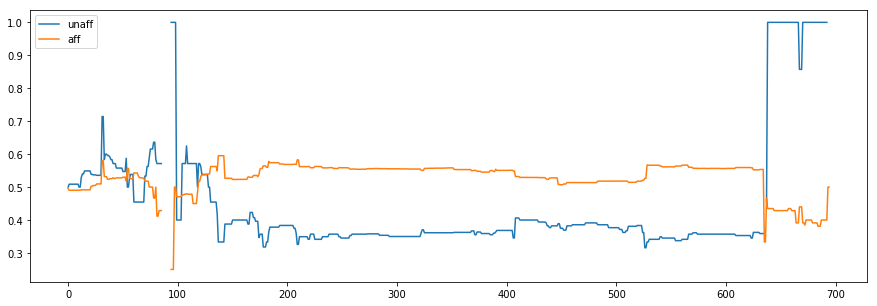

In [40]:

plt.figure(figsize=(15, 5))
plt.plot(c[:, 0, 1]/np.sum(c[:, 0, :], axis=1), label='unaff')
plt.plot(c[:, 1, 1]/np.sum(c[:, 1, :], axis=1), label='aff')

plt.legend()
plt.show()

In [41]:
d = ihart_deletions[-1][:, (np.array(all_positions[-1])>=start_pos) & (np.array(all_positions[-1])<=end_pos)]
print(d.shape)

(3994, 698)


In [42]:
trio_types = set()
for k in ihart_families:
    inds = family_to_individuals[k]
    indices = [ihart_ind_to_index[x] for x in inds]
    for child_id, child_index in zip(inds[2:], indices[2:]):
        trio_types.update([(d[indices[0], i], d[indices[1], i], d[child_index, i]) for i in range(d.shape[1])])
trio_types = sorted(trio_types)
trio_to_index = dict([(x, i) for i, x in enumerate(trio_types)])
print(trio_types)

[(-1, -1, 4), (-1, 0, 0), (-1, 1, 3), (-1, 1, 4), (-1, 2, 4), (-1, 3, 1), (-1, 4, -1), (-1, 4, 4), (0, 0, 0), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 2, 1), (0, 2, 3), (0, 4, 1), (0, 4, 3), (1, -1, 3), (1, -1, 4), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 1), (1, 2, 2), (1, 3, 0), (1, 3, 1), (1, 3, 3), (1, 3, 4), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (2, -1, 4), (2, 0, 1), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 2), (2, 3, 1), (2, 3, 4), (2, 4, 2), (2, 4, 4), (3, 0, 0), (3, 1, 0), (3, 1, 1), (3, 1, 3), (3, 1, 4), (3, 2, 1), (3, 2, 4), (3, 4, -1), (3, 4, 1), (3, 4, 3), (3, 4, 4), (4, -1, -1), (4, -1, 4), (4, 0, 0), (4, 0, 1), (4, 0, 3), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 2, 2), (4, 2, 4), (4, 3, -1), (4, 3, 0), (4, 3, 1), (4, 3, 3), (4, 3, 4), (4, 4, -1), (4, 4, 2), (4, 4, 4)]


In [43]:
trio_counts = np.zeros((len(trio_types), d.shape[1]), dtype=int)
trio_counts_a = np.zeros((len(trio_types), d.shape[1]), dtype=int)
trio_counts_u = np.zeros((len(trio_types), d.shape[1]), dtype=int)

for k in ihart_families:
    inds = family_to_individuals[k]
    indices = [ihart_ind_to_index[x] for x in inds]
    for child_id, child_index in zip(inds[2:], indices[2:]):
        trio_counts[[trio_to_index[(d[indices[0], i], d[indices[1], i], d[child_index, i])] for i in range(d.shape[1])], range(d.shape[1])] += 1
        
        if child_id_to_affected[child_id] == '2':
            trio_counts_a[[trio_to_index[(d[indices[0], i], d[indices[1], i], d[child_index, i])] for i in range(d.shape[1])], range(d.shape[1])] += 1
        elif child_id_to_affected[child_id] == '1':  
            trio_counts_u[[trio_to_index[(d[indices[0], i], d[indices[1], i], d[child_index, i])] for i in range(d.shape[1])], range(d.shape[1])] += 1

                           

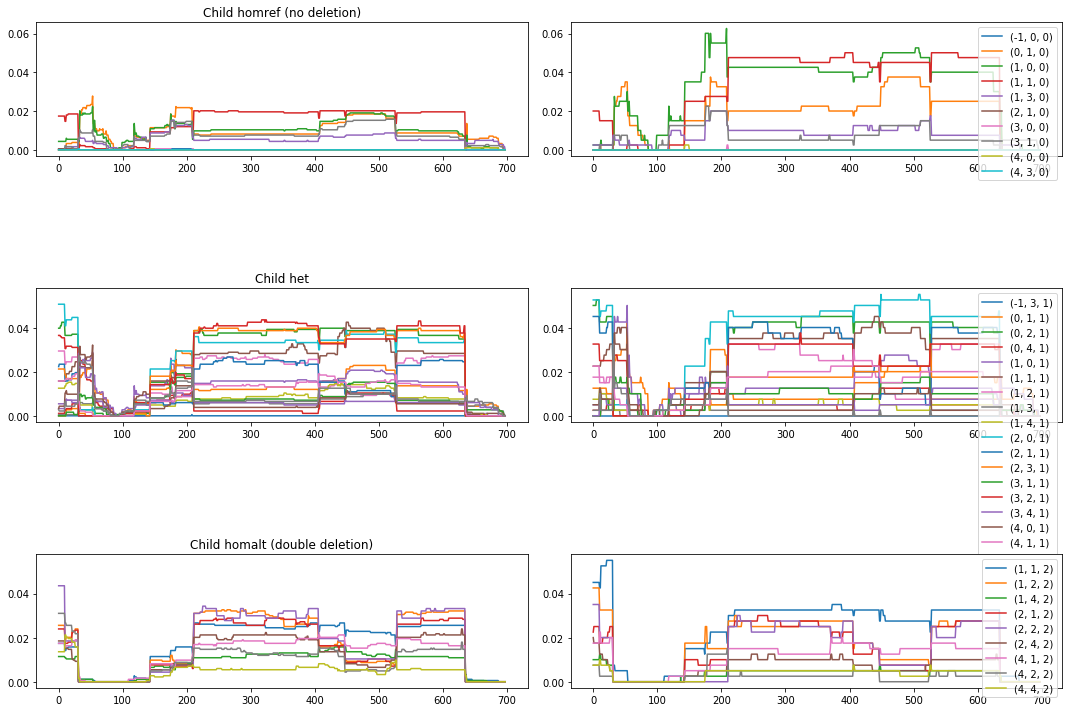

In [44]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.title('Child homref (no deletion)')
for i, trio_type in enumerate(trio_types):
    if trio_type != (0, 0, 0) and trio_type[2]==0:
        ax = plt.subplot(3, 2, 1)
        plt.plot(trio_counts_a[i, :]/np.sum(trio_counts_a, axis=0), label=trio_type)
        plt.subplot(3, 2, 2, sharey=ax)
        plt.plot(trio_counts_u[i, :]/np.sum(trio_counts_u, axis=0), label=trio_type)
plt.legend()

plt.subplot(3, 2, 3)
plt.title('Child het')
for i, trio_type in enumerate(trio_types):
    if trio_type != (0, 0, 0) and trio_type[2]==1:
        ax = plt.subplot(3, 2, 3)
        plt.plot(trio_counts_a[i, :]/np.sum(trio_counts_a, axis=0), label=trio_type)
        plt.subplot(3, 2, 4, sharey=ax)
        plt.plot(trio_counts_u[i, :]/np.sum(trio_counts_u, axis=0), label=trio_type)
plt.legend()

plt.subplot(3, 2, 5)
plt.title('Child homalt (double deletion)')
for i, trio_type in enumerate(trio_types):
    if trio_type != (0, 0, 0) and trio_type[2]==2:
        ax = plt.subplot(3, 2, 5)
        plt.plot(trio_counts_a[i, :]/np.sum(trio_counts_a, axis=0), label=trio_type)
        plt.subplot(3, 2, 6, sharey=ax)
        plt.plot(trio_counts_u[i, :]/np.sum(trio_counts_u, axis=0), label=trio_type) 
plt.legend()

plt.tight_layout()
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarni

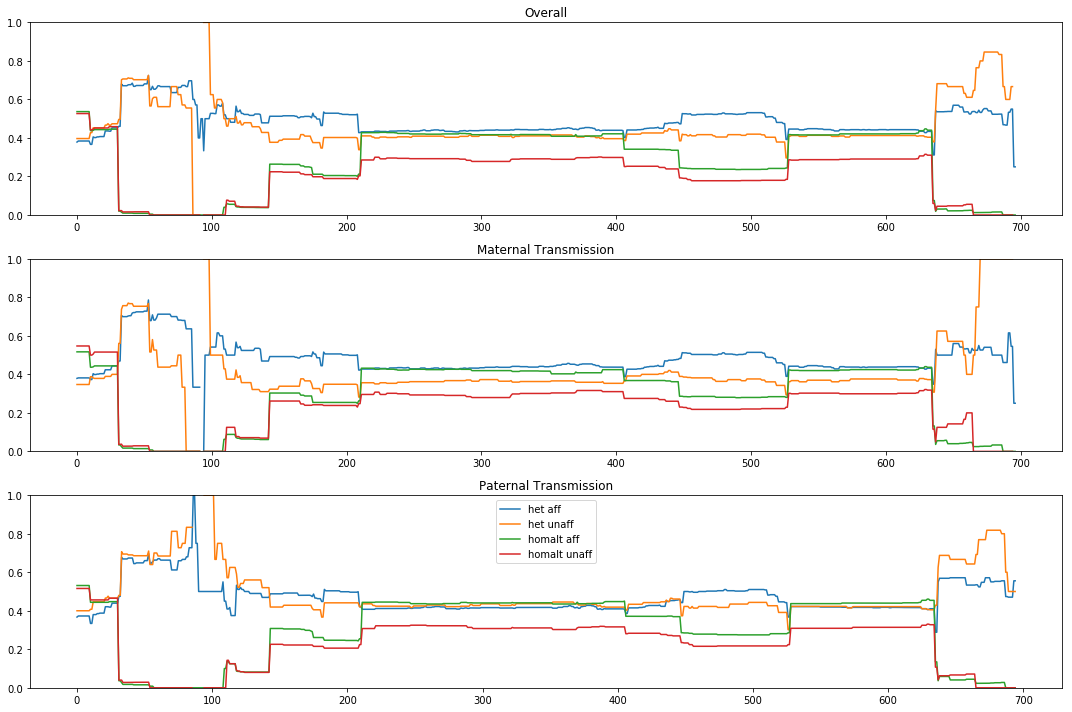

In [45]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
t_a = np.zeros((d.shape[1], 5), dtype=int)
t_u = np.zeros((d.shape[1], 5), dtype=int)

for i, trio_type in enumerate(trio_types):
    if trio_type[0] == 1 or trio_type[0] == 4 or trio_type[1] == 1 or trio_type[1] == 4:
        t_a[:, trio_type[2]] += trio_counts_a[i, :]
        t_u[:, trio_type[2]] += trio_counts_u[i, :]
        
#plt.plot(t_a[:, 0]/np.sum(t_a, axis=1), label='homref aff')
#plt.plot(t_u[:, 0]/np.sum(t_u, axis=1), label='homref unaff')

plt.plot(t_a[:, 1]/np.sum(t_a, axis=1), label='het aff')
plt.plot(t_u[:, 1]/np.sum(t_u, axis=1), label='het unaff')

plt.plot(t_a[:, 2]/np.sum(t_a, axis=1), label='homalt aff')
plt.plot(t_u[:, 2]/np.sum(t_u, axis=1), label='homalt unaff')
plt.title('Overall')
plt.ylim([0, 1])

plt.subplot(3, 1, 2)
t_a = np.zeros((d.shape[1], 5), dtype=int)
t_u = np.zeros((d.shape[1], 5), dtype=int)

for i, trio_type in enumerate(trio_types):
    if trio_type[0] == 1 or trio_type[0] == 4:
        t_a[:, trio_type[2]] += trio_counts_a[i, :]
        t_u[:, trio_type[2]] += trio_counts_u[i, :]
        
#plt.plot(t_a[:, 0]/np.sum(t_a, axis=1), label='homref aff')
#plt.plot(t_u[:, 0]/np.sum(t_u, axis=1), label='homref unaff')

plt.plot(t_a[:, 1]/np.sum(t_a, axis=1), label='het aff')
plt.plot(t_u[:, 1]/np.sum(t_u, axis=1), label='het unaff')

plt.plot(t_a[:, 2]/np.sum(t_a, axis=1), label='homalt aff')
plt.plot(t_u[:, 2]/np.sum(t_u, axis=1), label='homalt unaff')
plt.title('Maternal Transmission')
plt.ylim([0, 1])

plt.subplot(3, 1, 3)
t_a = np.zeros((d.shape[1], 5), dtype=int)
t_u = np.zeros((d.shape[1], 5), dtype=int)

for i, trio_type in enumerate(trio_types):
    if trio_type[1] == 1 or trio_type[1] == 4:
        t_a[:, trio_type[2]] += trio_counts_a[i, :]
        t_u[:, trio_type[2]] += trio_counts_u[i, :]
        
#plt.plot(t_a[:, 0]/np.sum(t_a, axis=1), label='homref aff')
#plt.plot(t_u[:, 0]/np.sum(t_u, axis=1), label='homref unaff')

plt.plot(t_a[:, 1]/np.sum(t_a, axis=1), label='het aff')
plt.plot(t_u[:, 1]/np.sum(t_u, axis=1), label='het unaff')

plt.plot(t_a[:, 2]/np.sum(t_a, axis=1), label='homalt aff')
plt.plot(t_u[:, 2]/np.sum(t_u, axis=1), label='homalt unaff')
plt.title('Paternal Transmission')
plt.ylim([0, 1])

plt.legend()
plt.tight_layout()
plt.show()

In [46]:
print(trio_types)

[(-1, -1, 4), (-1, 0, 0), (-1, 1, 3), (-1, 1, 4), (-1, 2, 4), (-1, 3, 1), (-1, 4, -1), (-1, 4, 4), (0, 0, 0), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 2, 1), (0, 2, 3), (0, 4, 1), (0, 4, 3), (1, -1, 3), (1, -1, 4), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 1), (1, 2, 2), (1, 3, 0), (1, 3, 1), (1, 3, 3), (1, 3, 4), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (2, -1, 4), (2, 0, 1), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 2), (2, 3, 1), (2, 3, 4), (2, 4, 2), (2, 4, 4), (3, 0, 0), (3, 1, 0), (3, 1, 1), (3, 1, 3), (3, 1, 4), (3, 2, 1), (3, 2, 4), (3, 4, -1), (3, 4, 1), (3, 4, 3), (3, 4, 4), (4, -1, -1), (4, -1, 4), (4, 0, 0), (4, 0, 1), (4, 0, 3), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 2, 2), (4, 2, 4), (4, 3, -1), (4, 3, 0), (4, 3, 1), (4, 3, 3), (4, 3, 4), (4, 4, -1), (4, 4, 2), (4, 4, 4)]


In [47]:
def plot_with_error(num, denom, label):
    f = num/denom
    e = [1.96*np.sqrt(x*(1-x)/n) for x, n in zip(f, denom)]
    
    xs = range(num.shape[0])
    p = plt.plot(xs, f, label=label)
    plt.fill_between(xs, [x-y for x, y in zip(f, e)], [x+y for x, y in zip(f, e)], color=p[0].get_color(), alpha=0.2)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


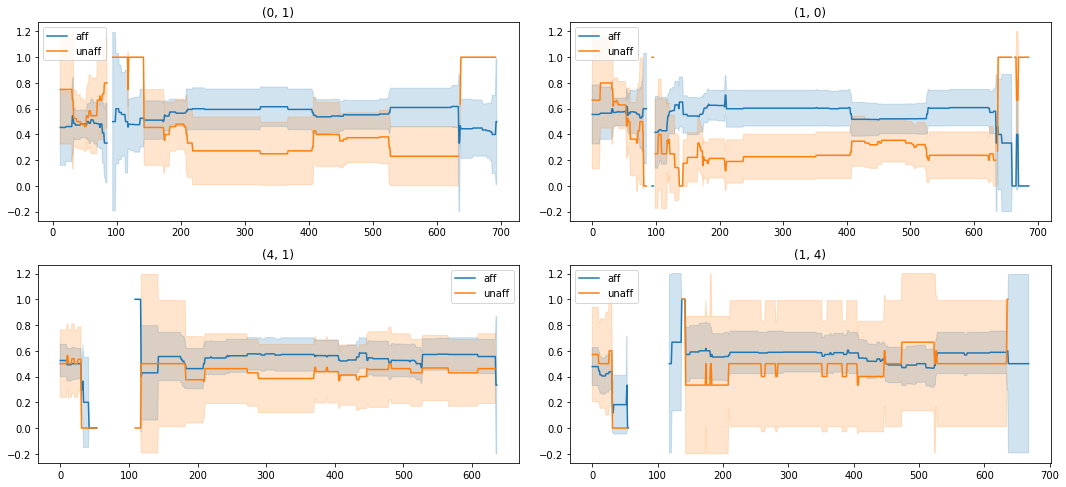

In [48]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(3, 2, 1)
plt.title('(0, 1)')
plot_with_error(trio_counts_a[trio_to_index[(0, 1, 1)]], (trio_counts_a[trio_to_index[(0, 1, 0)]]+trio_counts_a[trio_to_index[(0, 1, 1)]]), 'aff')
plot_with_error(trio_counts_u[trio_to_index[(0, 1, 1)]], (trio_counts_u[trio_to_index[(0, 1, 0)]]+trio_counts_u[trio_to_index[(0, 1, 1)]]), 'unaff')
plt.legend()

plt.subplot(3, 2, 2, sharey=ax)
plt.title('(1, 0)')
plot_with_error(trio_counts_a[trio_to_index[(1, 0, 1)]], (trio_counts_a[trio_to_index[(1, 0, 0)]]+trio_counts_a[trio_to_index[(1, 0, 1)]]), 'aff')
plot_with_error(trio_counts_u[trio_to_index[(1, 0, 1)]], (trio_counts_u[trio_to_index[(1, 0, 0)]]+trio_counts_u[trio_to_index[(1, 0, 1)]]), 'unaff')
plt.legend()

ax = plt.subplot(3, 2, 3)
plt.title('(4, 1)')
plot_with_error(trio_counts_a[trio_to_index[(4, 1, 2)]], (trio_counts_a[trio_to_index[(4, 1, 1)]]+trio_counts_a[trio_to_index[(4, 1, 2)]]), 'aff')
plot_with_error(trio_counts_u[trio_to_index[(4, 1, 2)]], (trio_counts_u[trio_to_index[(4, 1, 1)]]+trio_counts_u[trio_to_index[(4, 1, 2)]]), 'unaff')
plt.legend()

plt.subplot(3, 2, 4, sharey=ax)
plt.title('(1, 4)')
plot_with_error(trio_counts_a[trio_to_index[(1, 4, 2)]], (trio_counts_a[trio_to_index[(1, 4, 1)]]+trio_counts_a[trio_to_index[(1, 4, 2)]]), 'aff')
plot_with_error(trio_counts_u[trio_to_index[(1, 4, 2)]], (trio_counts_u[trio_to_index[(1, 4, 1)]]+trio_counts_u[trio_to_index[(1, 4, 2)]]), 'unaff')
plt.legend()

plt.tight_layout()
plt.show()